The goal of this sheet is to fit a linear model per node across our dataset and to determine the surviving nodes after FDR correction

In [39]:
import os 

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from scipy.stats import chi2

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    pass
data_df.head()

RANDOM_STATE = 42

In [2]:
df = data_df.drop(columns=["Data", "Connectome", "Harmonized", "CLU", "DIV", "Site", "Subject_ID", "Study"])
expanded_columns = []

for idx, row in df.iterrows():
    evc_matrix = row['EVC']
    if evc_matrix is not None:
        expanded_columns.append(evc_matrix.flatten())
    else:
        expanded_columns.append([np.nan] * 271)

evc_expanded = pd.DataFrame(expanded_columns, index=df.index)
evc_expanded.columns = [f'EVC_{i}' for i in range(evc_expanded.shape[1])]

df = pd.concat([df.drop(columns=['EVC']), evc_expanded], axis=1)

def get_cohort(d):
    return 'AD' if d in ['AD', 'HC'] else 'TBI'

def get_diag_status(d):
    return 'Case' if d in ['AD', 'POS'] else 'Control'

df['Cohort'] = df['Diagnosis'].apply(get_cohort)
df['DiagStatus'] = df['Diagnosis'].apply(get_diag_status)
df['Sex'] = df['Sex'].map({'M': 1, 'm': 1, 'F': 0, 'f': 0})
df['Cohort'] = pd.Categorical(df['Cohort'])
df['DiagStatus'] = pd.Categorical(df['DiagStatus'])
df = df.dropna(subset=['EVC_0'])


In [42]:
omnibus_pvals = []
term_pvals = {}
node_names = []
ALPHA = 0.05

for node in [col for col in df.columns if col.startswith("EVC_")]:
    null_model = smf.glm(
        formula=f"{node} ~ 1",
        data=df,
        family=sm.families.Gaussian()
    ).fit()

    full_model = smf.glm(
        formula=f"{node} ~ C(Cohort) + C(DiagStatus) + C(Cohort) * C(DiagStatus) + Age + Sex",
        data=df,
        family=sm.families.Gaussian()
    ).fit()

    # Likelihood ratio test
    ll_null = null_model.llf
    ll_full = full_model.llf
    lr_stat = 2 * (ll_full - ll_null)
    df_diff = full_model.df_model - null_model.df_model
    pval = 1 - chi2.cdf(lr_stat, df_diff)

    omnibus_pvals.append(pval)
    node_names.append(node)
    term_pvals[node] = full_model.pvalues 

rejected, corrected_pvals, _, _ = multipletests(omnibus_pvals, alpha=ALPHA, method='fdr_bh')
significant_nodes = [node for node, rej in zip(node_names, rejected) if rej]
print("Nodes with significant omnibus effect after FDR correction:")
print(significant_nodes, end="\n\n")

Nodes with significant omnibus effect after FDR correction:
['EVC_1', 'EVC_4', 'EVC_77', 'EVC_80', 'EVC_114', 'EVC_160']



C:\Users\Konnor\AppData\Local\Temp\ipykernel_18688\1619425637.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])


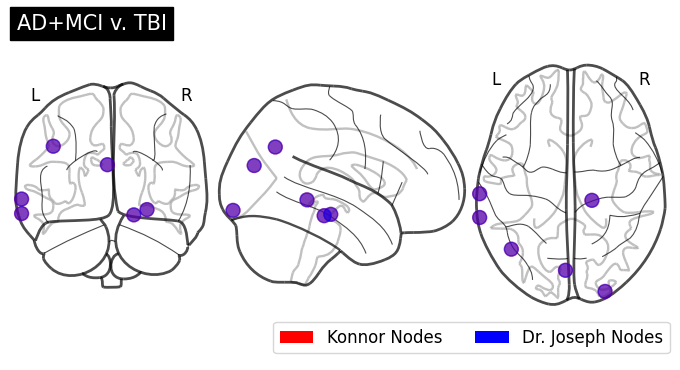

In [43]:
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

coord_df = pd.read_csv("data/top-10-nodes-analysis-3-10-25.csv")

static_nodes = [2, 7, 83, 86, 120, 167]
these_nodes = static_nodes
legend_elements = [
    Patch(facecolor="red", label="Konnor Nodes"),
    Patch(facecolor="blue", label="Dr. Joseph Nodes"),
]

these_df = coord_df[coord_df["Node"].isin(these_nodes)]
coords_these = these_df[["MNI-X", "MNI-Y", "MNI-Z"]].values

static_df = coord_df[coord_df["Node"].isin(static_nodes)]
coords_static = static_df[["MNI-X", "MNI-Y", "MNI-Z"]].values

all_coords = list(coords_these) + list(coords_static)
all_values = np.append(np.ones(len(coords_these)), (-1 * np.ones(len(coords_static))))

plotting.plot_markers(
    node_values=all_values,
    node_coords=all_coords,
    display_mode="ortho",
    title="AD+MCI v. TBI",
    annotate=True,
    colorbar=False,
    node_cmap="bwr",
    alpha=0.5,
)
plt.legend(
    handles=legend_elements,
    loc="lower center",
    ncol=2,
    fontsize=12,
    bbox_to_anchor=(0, -0.2),
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()